# Visualizing the SVD with the MNIST data set

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib_inline

# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# Load in the data
mnist_data_mat = scipy.io.loadmat("mnist.mat")
x_train = mnist_data_mat["train_data"]
y_train = mnist_data_mat["train_target"].flatten()
x_test  = mnist_data_mat["test_data"]
y_test  = mnist_data_mat["test_target"].flatten()

idcs_1 = y_train == 1
idcs_4 = y_train == -1

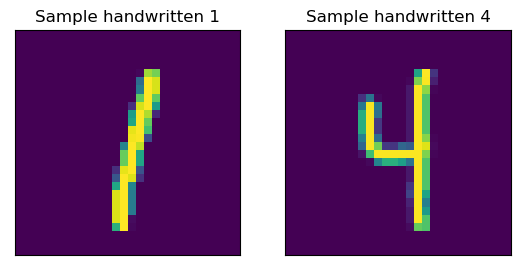

In [3]:
fig, axes = plt.subplots(1, 2)
ax0, ax1 = axes

ax0.set_title(f"Sample handwritten 1")
ax0.imshow(x_train[0].reshape(28, 28))
ax0.set_xticks([])
ax0.set_yticks([])

ax1.set_title(f"Sample handwritten 4")
ax1.imshow(x_train[-1].reshape(28, 28))
ax1.set_xticks([])
ax1.set_yticks([])
plt.show()

In [4]:
# De-mean the data matrix
x_train_dm = x_train - x_train.mean(axis=0) # de-meaned
x_test_dm = x_test - x_test.mean(axis=0) # de-meaned

# Take the SVD
U_tr, s_tr, Vh_tr = np.linalg.svd(x_train_dm, full_matrices=False)
U_te, s_te, Vh_te = np.linalg.svd(x_test, full_matrices=False)

## Visualize data

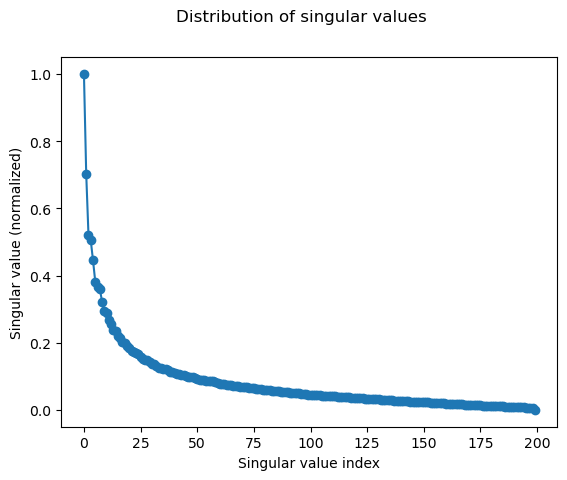

In [5]:
# Note: here we divide by the largest singular value to make it
# easier to read the relative scale of the other singular values.

fig, ax = plt.subplots(1)
fig.suptitle(f"Distribution of singular values")
ax.scatter(np.arange(s_tr.shape[0]), s_tr/s_tr.max())
ax.plot(np.arange(s_tr.shape[0]), s_tr/s_tr.max())
ax.set_ylabel(f"Singular value (normalized)")
ax.set_xlabel(f"Singular value index")
plt.show()

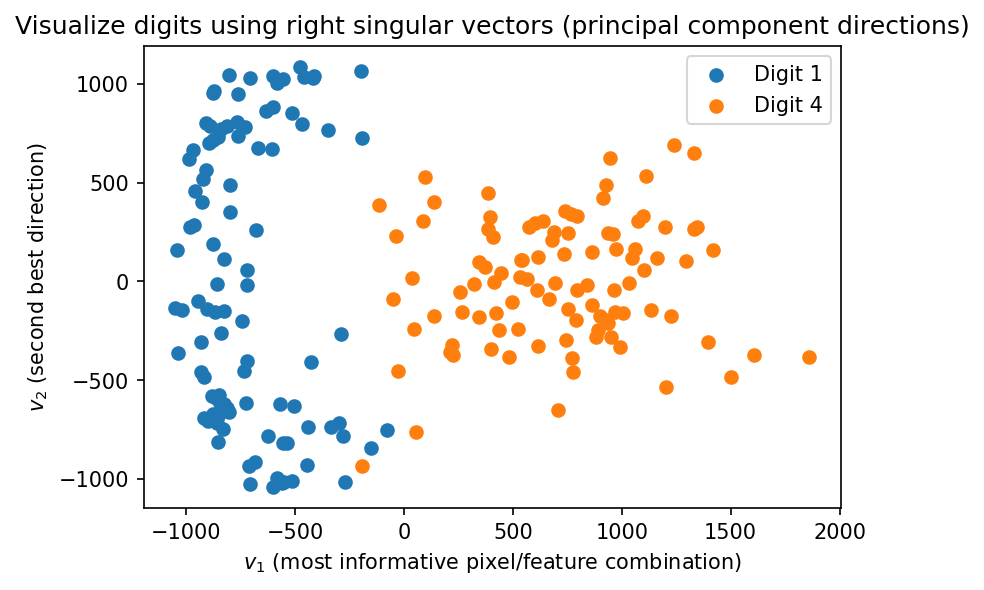

In [6]:
# Visualize the first two sigma_i u_i ~ descriptions of the differences between data points
# (Score plot)

# Project into the subspace given by the top 2 right singular vectors
# (also: principal component directions)
# x_train_vis = x_train_dm @ Vh_tr[:2].T # equivalent
x_train_vis = U_tr[:, :2] * s_tr[:2]

# Generate the plot
%matplotlib inline
fig, axes = plt.subplots(1, figsize=(6, 4), dpi=150)
ax1 = axes

ax1.set_title(f"Visualize digits using right singular vectors (principal component directions)")
ax1.scatter(*(x_train_vis[idcs_1].T), label=f"Digit 1")
ax1.scatter(*(x_train_vis[idcs_4].T), label=f"Digit 4")
ax1.set_xlabel(f"$v_1$ (most informative pixel/feature combination)")
ax1.set_ylabel(f"$v_2$ (second best direction)")
ax1.legend()

plt.show()

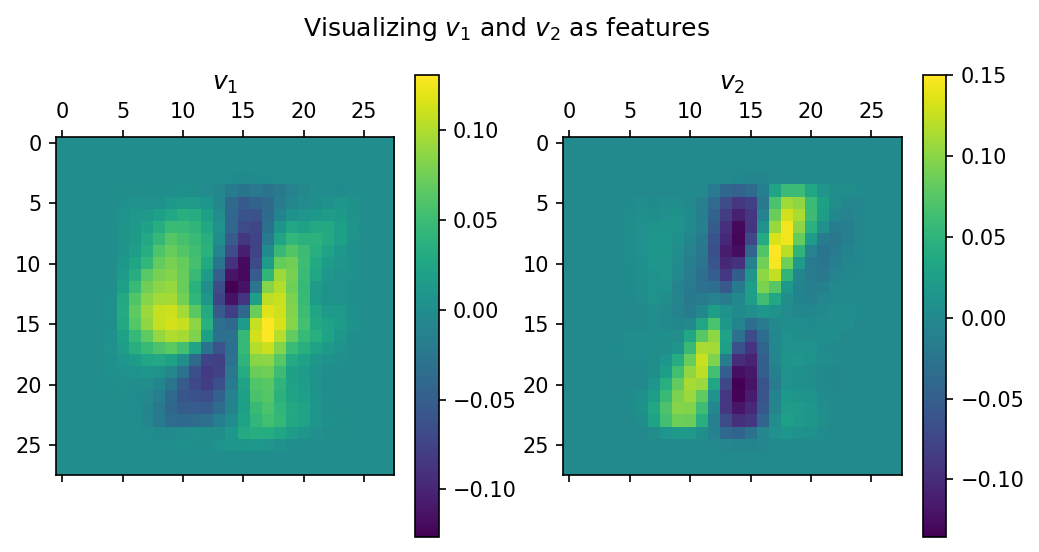

In [7]:
# Visualize the v_1 and v_2 right singular vectors
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
fig.suptitle("Visualizing $v_1$ and $v_2$ as features")

ax1, ax2  = axes
ax1.set_title("$v_1$")
im1 = ax1.matshow(Vh_tr[0, :].reshape(28, 28))
plt.colorbar(im1, ax=ax1)

ax2.set_title("$v_2$")
im2 = ax2.matshow(Vh_tr[1, :].reshape(28, 28))
plt.colorbar(im2, ax=ax2)
plt.show()

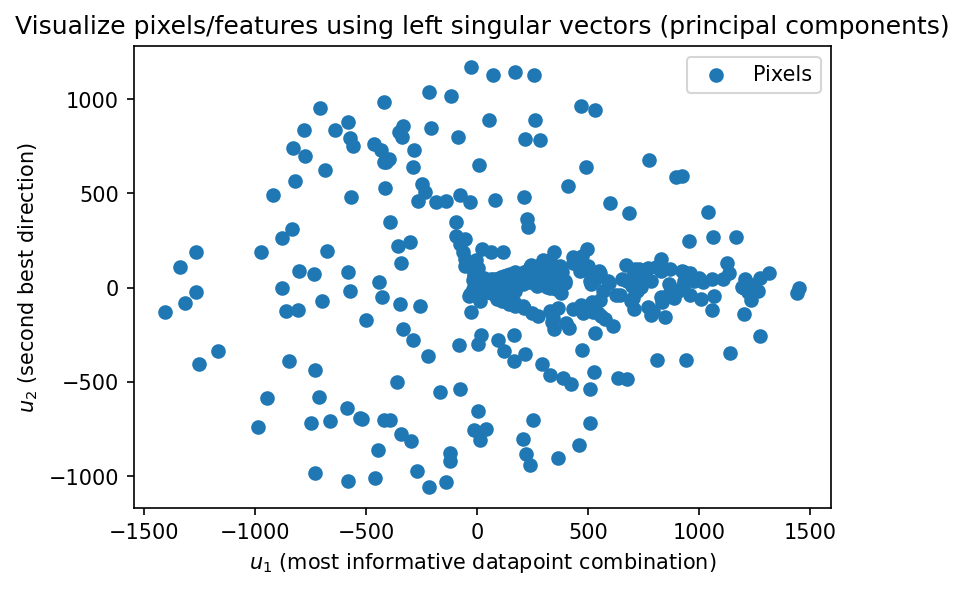

In [8]:
# Visualize the first two sigma_i v_i ~ descriptions of the differences between pixels
# (Score plot)

# Project into the subspace given by the top 2 right singular vectors
# (also: principal components)
x_train_vis_2 = U_tr[:, :2].T @ x_train_dm

# Generate the plot
%matplotlib inline
fig, axes = plt.subplots(1, figsize=(6,4), dpi=150)
ax1 = axes

ax1.set_title(f"Visualize pixels/features using left singular vectors (principal components)")
ax1.scatter(*(x_train_vis_2), label="Pixels")
ax1.set_xlabel(f"$u_1$ (most informative datapoint combination)")
ax1.set_ylabel(f"$u_2$ (second best direction)")
ax1.legend()

# # Not worth writing...
# for i, xy in enumerate(x_train_vis_2.T):
#     ax1.annotate(f"({i//28}, {i % 28})", xy)
plt.show()

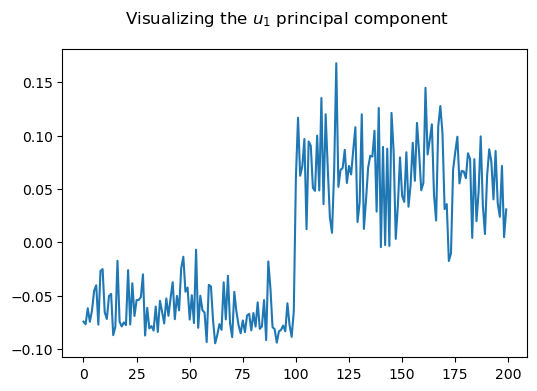

In [9]:
fig, (ax1) = plt.subplots(1,1, figsize=(6, 4), dpi=100)
plt.suptitle("Visualizing the $u_1$ principal component")
ax1.plot(np.arange(200), U_tr[:, 0])
plt.show()

In [10]:
# Try using a single pixel to make predictions?
pi_max = np.argmax(x_train_vis_2[0])

## Perform regression with 2 PCs

The objective can be simplified
$$
\begin {align*}
\lVert Zw - y \rVert_2^2
&= \left\lVert U \Sigma V^T \begin{bmatrix} v_1 & v_2 \end{bmatrix} w - y \right\rVert_2^2 \\
&= \left\lVert \Sigma V^T \begin{bmatrix} v_1 & v_2 \end{bmatrix} w - U^Ty \right\rVert_2^2 \\
&= \left\lVert \begin{pmatrix} \sigma_1 & 0 \\ 0 & \sigma_2 \end{pmatrix} \begin{pmatrix}w_1 \\ w_2 \end{pmatrix} - \begin {pmatrix} u_1^T y \\ u_2^T y \end {pmatrix}\right\rVert_2^2 
+ \left\lVert \begin {bmatrix}u_3 & \cdots & u_n \end{bmatrix}^T y \right\rVert_2^2
\end {align*}
$$
is minimized by
$$
\begin{pmatrix}w_1 \\ w_2 \end{pmatrix} 
= \begin {pmatrix} u_1^T y / \sigma_1 \\ u_2^T y / \sigma_2 \end {pmatrix}
$$
(sends the first term to zero; second term is fixed)

In [11]:
# wi = ui^T y / si
w = U_tr[:, :2].T @ y_train / s_tr[:2]
print(f"w={w}")

loss_train = np.linalg.norm(y_train - x_train_vis @ w, ord=2)**2

Ztest = x_test_dm @ Vh_te[:2].T
loss_test = np.linalg.norm(y_test - Ztest @ w, ord=2)**2

print(f"Training loss: {loss_train: .3f}")
print(f"Test loss: {loss_test: .3f}")

w=[-1.15292609e-03  3.23332851e-07]
Training loss:  36.245
Test loss:  354.950


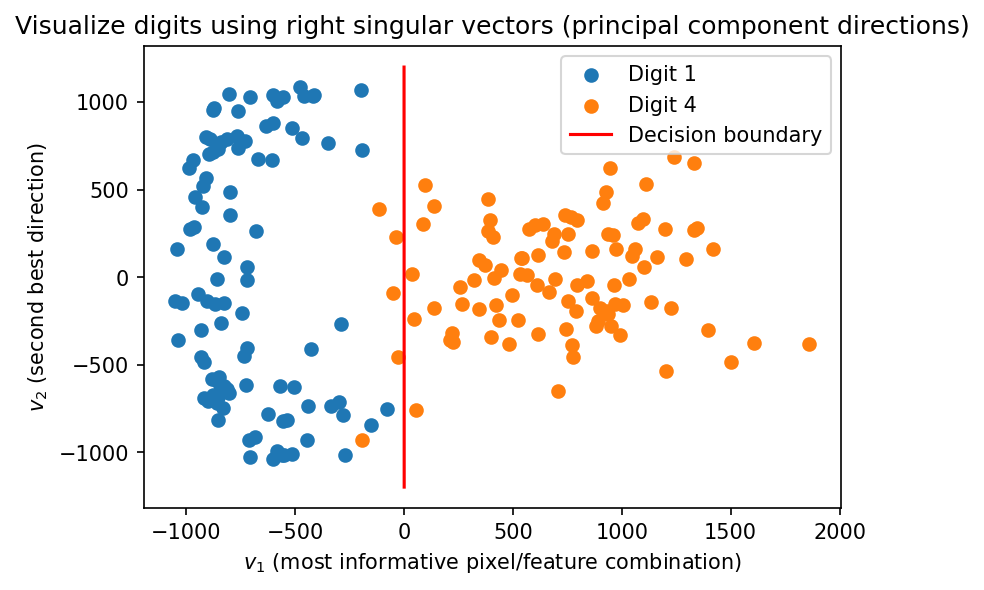

In [12]:
# Visualize the first two sigma_i u_i ~ descriptions of the differences between data points
# (Score plot)

# Project into the subspace given by the top 2 right singular vectors
# (also: principal component directions)
x_train_vis = x_train_dm @ Vh_tr[:2].T

decision_boundary = np.array([[-1200, 1200]])*np.array([[w[1]/w[0]], [1]])

# Generate the plot
%matplotlib inline
fig, axes = plt.subplots(1, figsize=(6, 4), dpi=150)
ax1 = axes

ax1.set_title(f"Visualize digits using right singular vectors (principal component directions)")
ax1.scatter(*(x_train_vis[idcs_1].T), label=f"Digit 1")
ax1.scatter(*(x_train_vis[idcs_4].T), label=f"Digit 4")
# ax1.plot((-1000*w[1]/w[0], 1000*w[1]/w[0]), (-1000, 1000))
ax1.plot(*decision_boundary, color='red', label="Decision boundary")
ax1.set_xlabel(f"$v_1$ (most informative pixel/feature combination)")
ax1.set_ylabel(f"$v_2$ (second best direction)")
ax1.legend()

plt.show()